# Loading the data and python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
# New
from scikeras.wrappers import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


In [2]:
# Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import yfinance as yf

Obtain features (original from Katsat + five new features)

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np

start_date = '2010-01-01'
end_date = '2024-12-31'
forward_days = 5

target_ticker = 'BTC-USD'
stock_tickers = ['IBM', 'GOOGL', 'MSFT']
index_tickers = ['^GSPC', '^DJI', '^VIX']
new_tickers = ['SPY', 'GLD']

def process_ticker(ticker, save_prefix=None):
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)[['Open', 'High', 'Low', 'Close']].dropna()
    df['Date'] = df.index.strftime('%Y%m%d').astype(int)
    df['FutureRet'] = np.log(df['Close'].shift(-forward_days)) - np.log(df['Close'])
    df = df.dropna()
    prefix = save_prefix or ticker.replace('^', '').replace('-', '')
    df.to_csv(f"{prefix}_FutRet.csv", index=False)
    df[['Open', 'High', 'Low', 'Close']].to_csv(f"{prefix}.txt", sep=' ', index=False, header=False)

tickers_to_process = [target_ticker] + stock_tickers + index_tickers + new_tickers
for tkr in tickers_to_process:
    process_ticker(tkr)

dix_gex = pd.read_csv('DIX_GEX_SP500.csv', parse_dates=['date'], index_col='date')
dix = dix_gex['dix']

gex = dix_gex['gex']

liq = pd.read_csv('Liquidity1.csv', parse_dates=['Date'], index_col='Date')
liq = liq.rename(columns={liq.columns[0]: 'LIQUIDITY'})
liq['liq_norm'] = (liq['LIQUIDITY'] - liq['LIQUIDITY'].mean()) / liq['LIQUIDITY'].std()
liq['liq_norm'].dropna().to_csv('Liquidity_norm.txt', sep=' ', header=False)
liq = liq['liq_norm']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Download DEXJPUS and DEXUSUK separately using pandas_datareader

DEXJPUS and DEXUSUK are exchange rates.
DEXJPUS: Yen per U.S. Dollar (JPY/USD);
DEXUSUKL: U.S. Dollar per British Pound (USD/GBP)

In [5]:

from pandas_datareader import data as web

# FRED FX tickers: Yen/USD and USD/GBP
fx_tickers = ['DEXJPUS', 'DEXUSUK']
fx_data = web.DataReader(fx_tickers, 'fred', start=start_date, end=end_date)

fx_data = fx_data.fillna(method='ffill').dropna()

fx_ret = np.log(fx_data).diff(forward_days).dropna()

for ticker in fx_ret.columns:
    norm = (fx_ret[ticker] - fx_ret[ticker].mean()) / fx_ret[ticker].std()
    norm.dropna().to_csv(f"{ticker}_norm.txt", sep=' ', header=False)

fx_ret.to_csv("FX_FutRet.csv")

fx_df = pd.read_csv("FX_FutRet.csv", parse_dates=['DATE'], index_col='DATE')

dexjpus = fx_df['DEXJPUS']
dexusuk = fx_df['DEXUSUK']


modify the csv files and combine all features

In [6]:
import pandas as pd

return_period = 5
# Target variable: BTC future return
# Read the BTC return file, skipping the two bad header rows
btc_df = pd.read_csv('BTCUSD_FutRet.csv', header=None, skiprows=2)

# Extract and clean the two needed columns: Date and FutureRet
Y = btc_df[[4, 5]].copy()
Y.columns = ['Date', 'BTC_ret']
Y.index = pd.to_datetime(Y['Date'].astype(str), format='%Y%m%d')
Y = Y[['BTC_ret']]

# Original features
googl_df = pd.read_csv('GOOGL_FutRet.csv', header=None, skiprows=2)
googl = googl_df[[4, 5]].copy()
googl.columns = ['Date', 'GOOGL_ret']
googl.index = pd.to_datetime(googl['Date'].astype(str), format='%Y%m%d')
googl = googl[['GOOGL_ret']]

ibm_df = pd.read_csv('IBM_FutRet.csv', header=None, skiprows=2)
ibm = ibm_df[[4, 5]].copy()
ibm.columns = ['Date', 'ibm_ret']
ibm.index = pd.to_datetime(ibm['Date'].astype(str), format='%Y%m%d')
ibm = ibm[['ibm_ret']]

sp500_df = pd.read_csv('GSPC_FutRet.csv', header=None, skiprows=2)
sp500 = sp500_df[[4, 5]].copy()
sp500.columns = ['Date', 'sp500_ret']
sp500.index = pd.to_datetime(sp500['Date'].astype(str), format='%Y%m%d')
sp500 = sp500[['sp500_ret']]

vix_df = pd.read_csv('VIX_FutRet.csv', header=None, skiprows=2)
vix = vix_df[[4, 5]].copy()
vix.columns = ['Date', 'vix_ret']
vix.index = pd.to_datetime(vix['Date'].astype(str), format='%Y%m%d')
vix = vix[['vix_ret']]

dji_df = pd.read_csv('DJI_FutRet.csv', header=None, skiprows=2)
dji = dji_df[[4, 5]].copy()
dji.columns = ['Date', 'dji_ret']
dji.index = pd.to_datetime(dji['Date'].astype(str), format='%Y%m%d')
dji = dji[['dji_ret']]

msft_df = pd.read_csv('MSFT_FutRet.csv', header=None, skiprows=2)
msft = msft_df[[4, 5]].copy()
msft.columns = ['Date', 'msft_ret']
msft.index = pd.to_datetime(msft['Date'].astype(str), format='%Y%m%d')
msft = msft[['msft_ret']]


# New features
spy_df = pd.read_csv('SPY_FutRet.csv', header=None, skiprows=2)
spy = spy_df[[4, 5]].copy()
spy.columns = ['Date', 'spy_ret']
spy.index = pd.to_datetime(spy['Date'].astype(str), format='%Y%m%d')
spy = spy[['spy_ret']]

gld_df = pd.read_csv('GLD_FutRet.csv', header=None, skiprows=2)
gld = gld_df[[4, 5]].copy()
gld.columns = ['Date', 'gld_ret']
gld.index = pd.to_datetime(gld['Date'].astype(str), format='%Y%m%d')
gld = gld[['gld_ret']]

X = pd.concat([googl, ibm, dexjpus, dexusuk, sp500, dji, vix, msft, spy, gld, dix, gex, liq], axis=1)
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period]

# Final X and Y
Y_final = dataset['BTC_ret']
X_final = dataset.drop(columns='BTC_ret')


# Exploratory Data Analysis

In [7]:
dataset.shape 

(75, 14)

In [8]:
dataset.head()

,BTC_ret,GOOGL_ret,ibm_ret,DEXJPUS,DEXUSUK,sp500_ret,dji_ret,vix_ret,msft_ret,spy_ret,gld_ret,dix,gex,liq_norm
2014-09-17,-0.128584,0.008609,-0.002545,0.007651,0.012014,-0.001635,0.003097,0.047849,0.011966,-0.001282,-0.004177,0.416406,3.581607e+09,0.760056
2014-10-22,-0.082010,0.028627,0.010269,0.011810,0.006931,0.028236,0.030688,-0.165123,0.049241,0.027740,-0.024858,0.408955,1.787901e+09,0.786479
2014-11-26,0.029095,-0.009447,0.012883,-0.000850,0.007439,-0.000439,0.004050,0.025359,0.022570,0.000097,0.006233,0.403710,3.868883e+09,0.819428
2014-12-31,-0.154067,-0.045788,-0.012670,-0.004994,0.001863,0.001572,0.004747,-0.121109,0.024246,0.001750,0.020565,0.422317,2.250908e+09,0.573124
2015-02-04,-0.030175,0.022367,0.014860,-0.001360,0.002897,0.013148,0.010644,-0.077681,0.012824,0.013967,-0.037800,0.418950,1.986467e+09,0.763448


In [9]:
dataset.describe()

,BTC_ret,GOOGL_ret,ibm_ret,DEXJPUS,DEXUSUK,sp500_ret,dji_ret,vix_ret,msft_ret,spy_ret,gld_ret,dix,gex,liq_norm
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,7.500000e+01,75.000000
mean,0.007283,0.004561,0.002090,-0.001804,0.001931,0.003704,0.002929,0.009396,0.006154,0.004134,-0.000265,0.423117,3.422971e+09,0.850298
std,0.085142,0.033245,0.028220,0.011616,0.013030,0.020864,0.021402,0.163873,0.026871,0.020623,0.018286,0.026310,3.033521e+09,0.506201
min,-0.246090,-0.103727,-0.071200,-0.040101,-0.027259,-0.048977,-0.046918,-0.319208,-0.081462,-0.047095,-0.043213,0.350469,-2.235911e+09,0.246922
25%,-0.033630,-0.011780,-0.012149,-0.006708,-0.005488,-0.006054,-0.008122,-0.102340,-0.004457,-0.005625,-0.011956,0.407533,1.862796e+09,0.556917
50%,0.009581,0.008500,0.000922,-0.000581,0.000448,0.002011,0.001765,0.012175,0.006489,0.002293,-0.001562,0.418950,2.944274e+09,0.713592
75%,0.038556,0.021131,0.014999,0.003962,0.009269,0.012142,0.011041,0.080034,0.020863,0.012607,0.013673,0.438495,4.521155e+09,0.815450
max,0.267203,0.144602,0.126265,0.029044,0.052253,0.107173,0.112341,0.681887,0.082129,0.107297,0.036781,0.511401,1.647941e+10,2.262806


Data Visualization

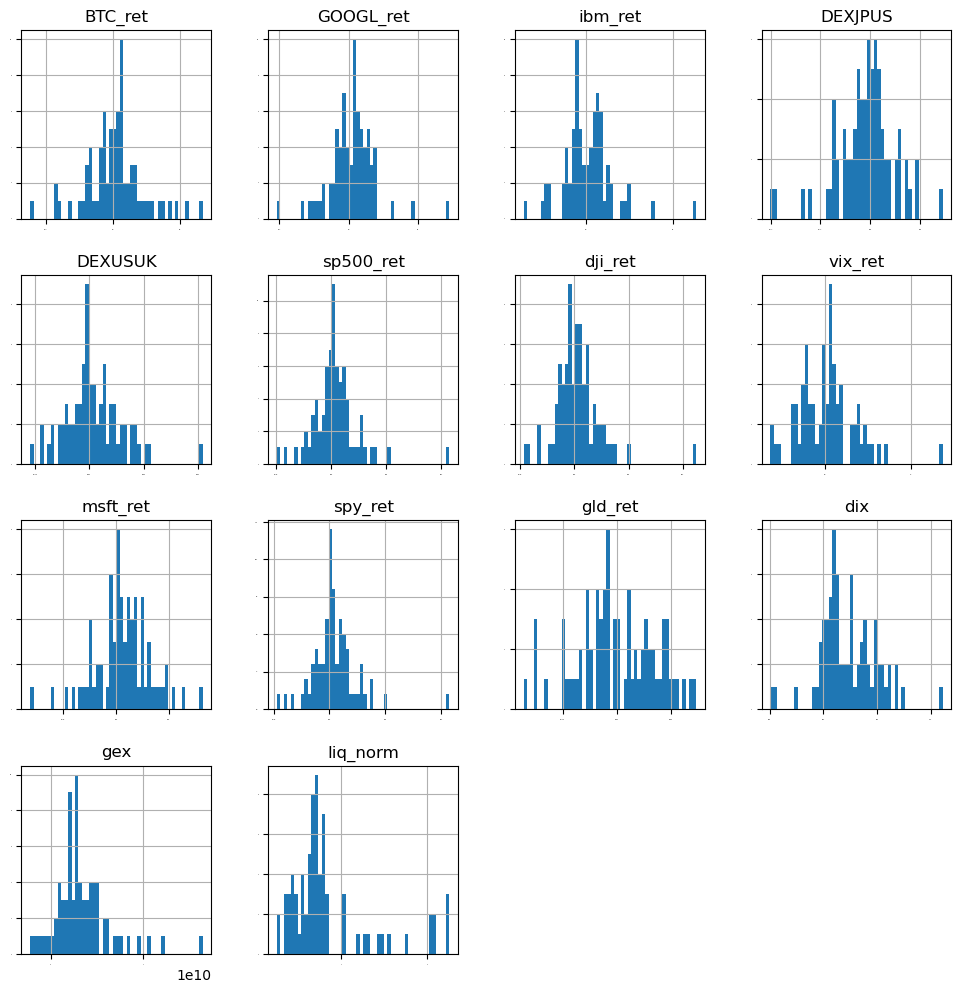

In [10]:
dataset.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

<Axes: title={'center': 'Correlation Matrix'}>

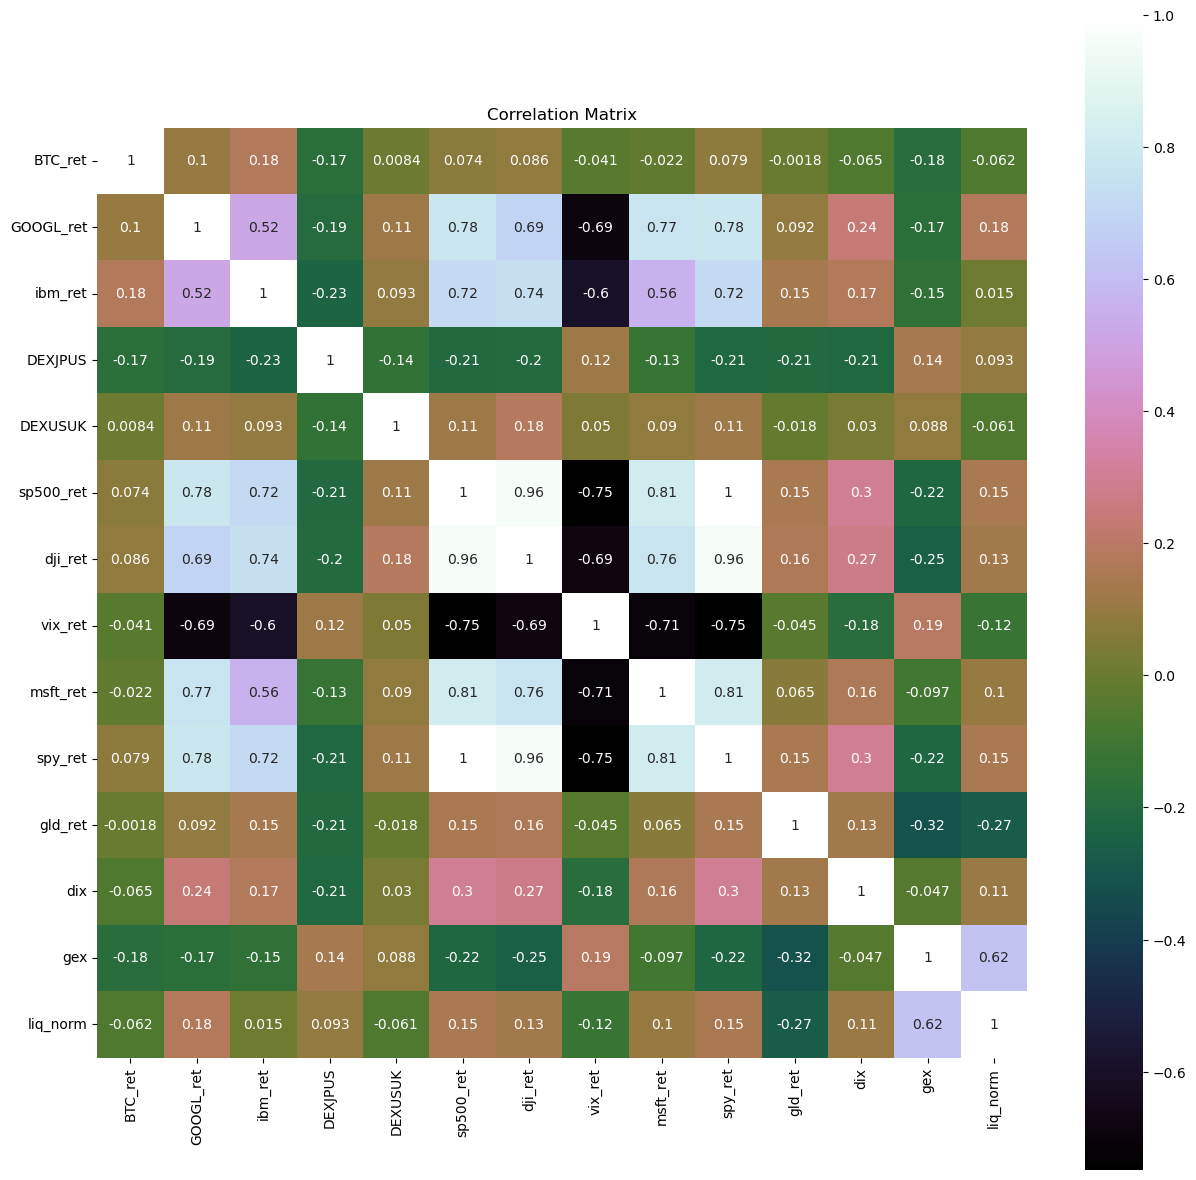

In [11]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

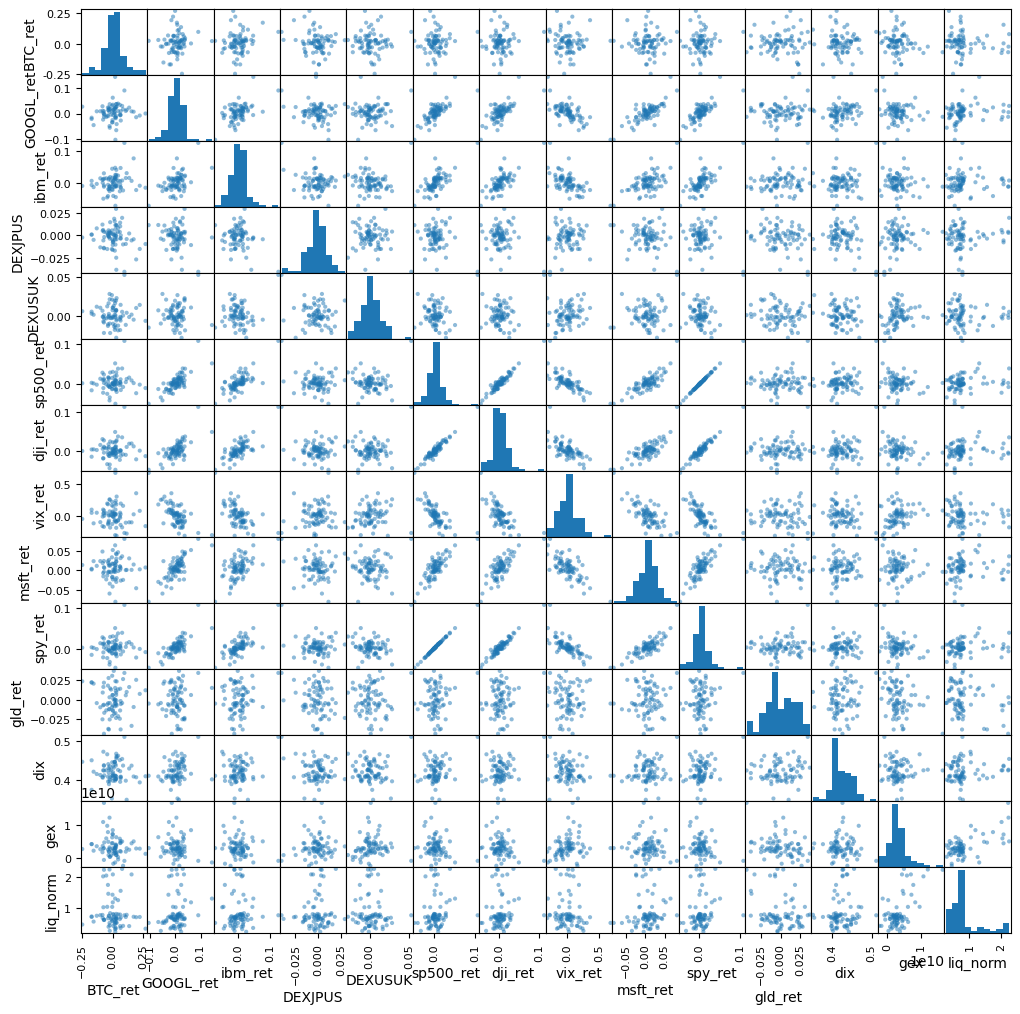

In [12]:
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

# Run Model

Time Series Analysis

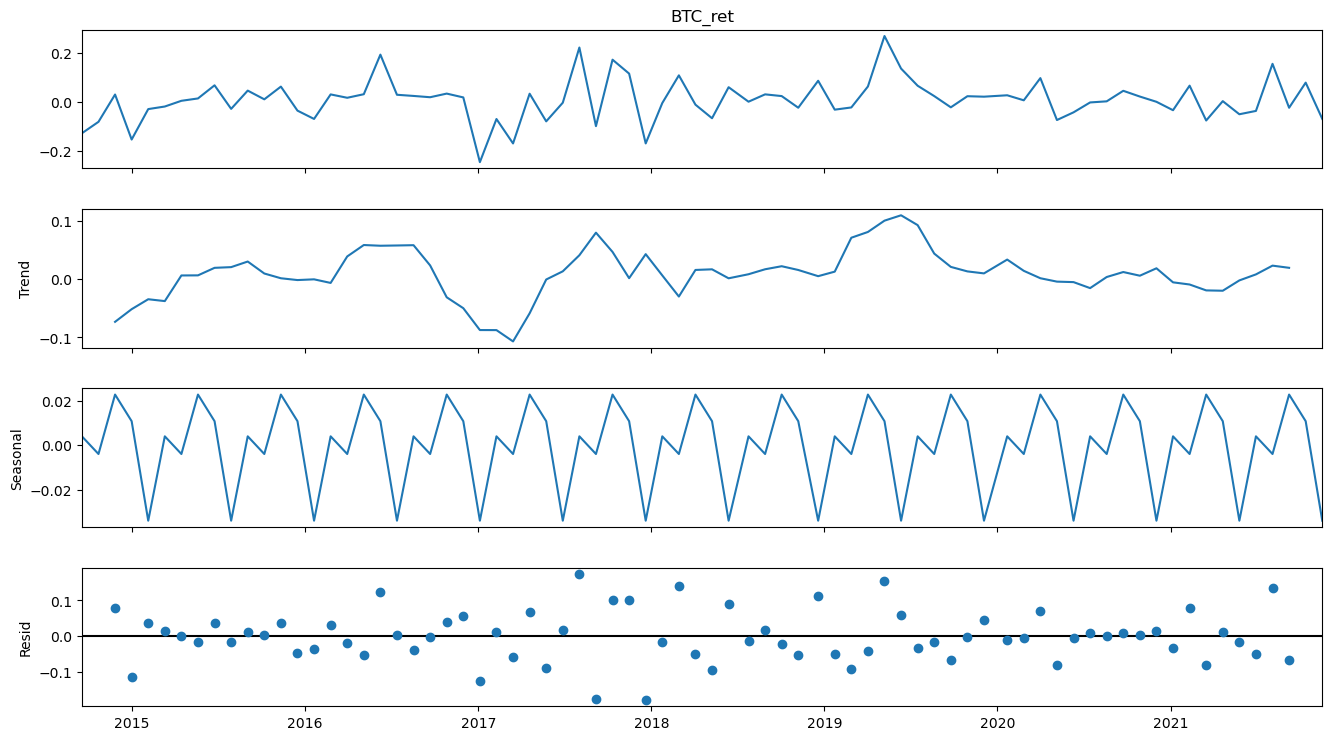

In [13]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

Y_final.index = pd.to_datetime(Y_final.index)

decomp = sm.tsa.seasonal_decompose(Y_final, model='additive', period=5)

fig = decomp.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()


Data Preparation

1. Feature selection

In [14]:
from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd

# Run SelectKBest
k = 10  # Change to 5 if you want fewer features
selector = SelectKBest(score_func=f_regression, k=k)
selector.fit(X_final, Y_final)

# Get feature scores and names
feature_scores = pd.DataFrame(selector.scores_, index=X_final.columns, columns=['Score'])
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

# Display top features
top_features = feature_scores.head(k)
print("Top features:\n", top_features)

Top features:
               Score
ibm_ret    2.349230
gex        2.336375
DEXJPUS    2.285961
GOOGL_ret  0.734048
dji_ret    0.537958
spy_ret    0.453421
sp500_ret  0.400990
dix        0.308736
liq_norm   0.281895
vix_ret    0.124043


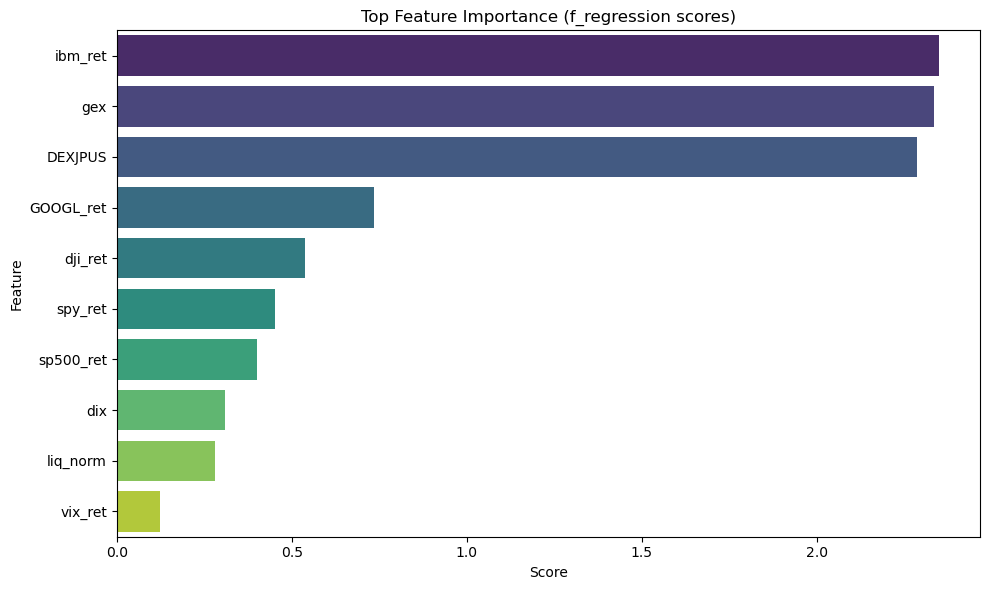

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features['Score'], y=top_features.index, palette='viridis')
plt.title('Top Feature Importance (f_regression scores)')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [16]:
X_top = selector.transform(X_final)

selected_features = X_final.columns[selector.get_support()]
X_top_df = pd.DataFrame(X_top, columns=selected_features, index=X_final.index)

print("Reduced feature dataset shape:", X_top_df.shape)


Reduced feature dataset shape: (75, 10)


5. Evaluate Algorithms and Models

In [17]:
train_size = int(len(X_final) * 0.8)
X_train, X_test = X_final[:train_size], X_final[train_size:]
Y_train, Y_test = Y_final[:train_size], Y_final[train_size:]

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
from sklearn.model_selection import KFold, cross_val_score

num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

kfold = KFold(n_splits=num_folds, shuffle=False)  # Keep time order


In [20]:
models = []
models.append(('LR', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('RF', RandomForestRegressor()))
models.append(('SVR', SVR()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

results = []
names = []

for name, model in models:
    cv_results = cross_val_score(model, X_train_scaled, Y_train, cv=kfold, scoring=scoring)
    rmse_scores = np.sqrt(-cv_results)
    results.append((name, rmse_scores.mean()))
    print(f"{name:10s} CV RMSE: {rmse_scores.mean():.5f}")


LR         CV RMSE: 0.10635
Lasso      CV RMSE: 0.08323
ElasticNet CV RMSE: 0.08323
RF         CV RMSE: 0.08628
SVR        CV RMSE: 0.09492
KNN        CV RMSE: 0.09715
GBR        CV RMSE: 0.09960


In [21]:
results_df = pd.DataFrame(results, columns=['Model', 'CV_RMSE'])
results_df = results_df.sort_values(by='CV_RMSE')
print(results_df.reset_index(drop=True))

        Model   CV_RMSE
0       Lasso  0.083225
1  ElasticNet  0.083225
2          RF  0.086276
3         SVR  0.094923
4         KNN  0.097145
5         GBR  0.099597
6          LR  0.106353


Compare Models and Algorithms

In [22]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'
kfold = KFold(n_splits=num_folds, shuffle=False)

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor
)

models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('MLP', MLPRegressor(max_iter=1000)))
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))


Model Evaluation

In [23]:
names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models:
    names.append(name)

    cv_results = -1 * cross_val_score(model, X_train_scaled, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)

    model.fit(X_train_scaled, Y_train)

    train_mse = mean_squared_error(Y_train, model.predict(X_train_scaled))
    train_results.append(train_mse)

    test_mse = mean_squared_error(Y_test, model.predict(X_test_scaled))
    test_results.append(test_mse)

    print(f"{name:5s} | CV RMSE: {np.sqrt(cv_results.mean()):.6f} | Train RMSE: {np.sqrt(train_mse):.6f} | Test RMSE: {np.sqrt(test_mse):.6f}")


LR    | CV RMSE: 0.113071 | Train RMSE: 0.080094 | Test RMSE: 0.118862
LASSO | CV RMSE: 0.092770 | Train RMSE: 0.089775 | Test RMSE: 0.059385
EN    | CV RMSE: 0.092770 | Train RMSE: 0.089775 | Test RMSE: 0.059385
KNN   | CV RMSE: 0.103666 | Train RMSE: 0.088487 | Test RMSE: 0.077296
CART  | CV RMSE: 0.127488 | Train RMSE: 0.000000 | Test RMSE: 0.084657
SVR   | CV RMSE: 0.101818 | Train RMSE: 0.072599 | Test RMSE: 0.061212
MLP   | CV RMSE: 0.200849 | Train RMSE: 0.056516 | Test RMSE: 0.241573
ABR   | CV RMSE: 0.092990 | Train RMSE: 0.033695 | Test RMSE: 0.071946
GBR   | CV RMSE: 0.102752 | Train RMSE: 0.003255 | Test RMSE: 0.073917
RFR   | CV RMSE: 0.092956 | Train RMSE: 0.038493 | Test RMSE: 0.065537
ETR   | CV RMSE: 0.092300 | Train RMSE: 0.000000 | Test RMSE: 0.065867


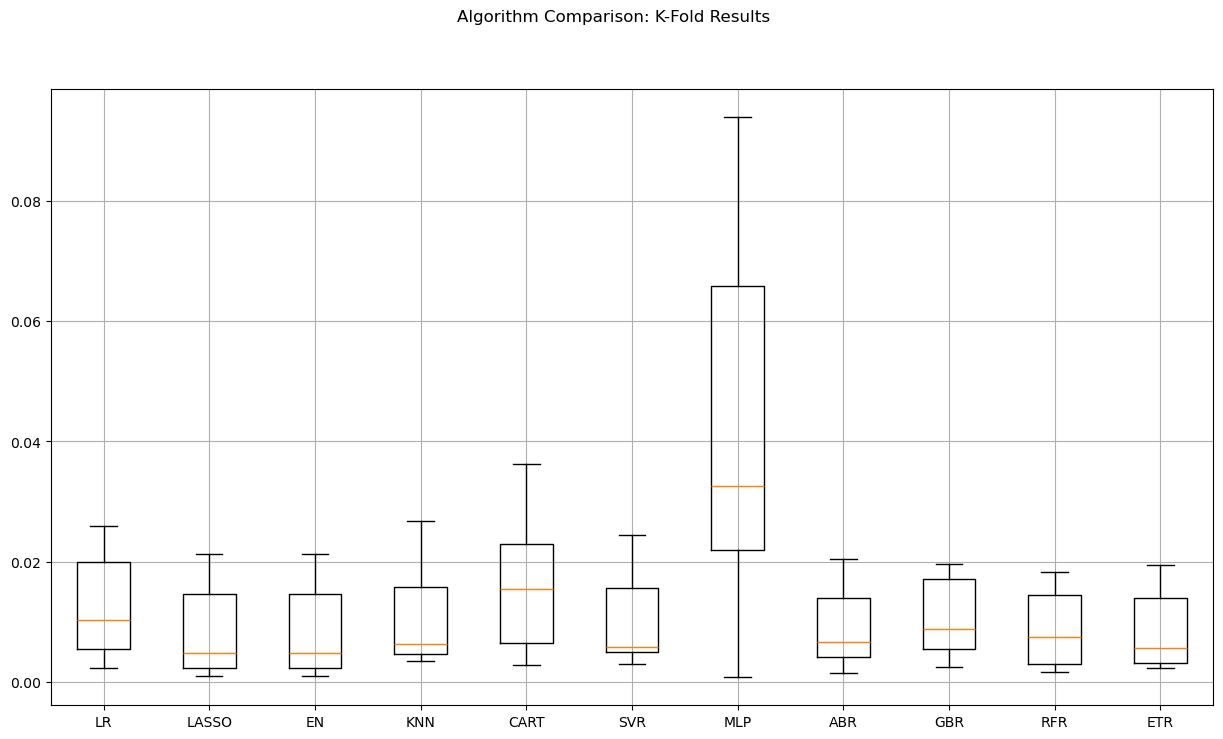

In [24]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: K-Fold Results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
plt.grid(True)
plt.show()

The Lasso and ElasticNet models achieved the lowest and most consistent RMSE scores, indicating strong predictive performance and stability across folds. Tree-based ensemble models like Random Forest and Gradient Boosting performed reasonably well but with slightly more variance. MLP and Decision Tree showed higher error and instability, making them less reliable without further tuning.

In [25]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

final_model = Lasso()
final_model.fit(X_train_scaled, Y_train)

y_pred = final_model.predict(X_test_scaled)

test_rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)

print(f"Final Model: LASSO")
print(f"Test RMSE: {test_rmse:.6f}")
print(f"R² Score: {r2:.4f}")


Final Model: LASSO
Test RMSE: 0.059385
R² Score: -0.0036


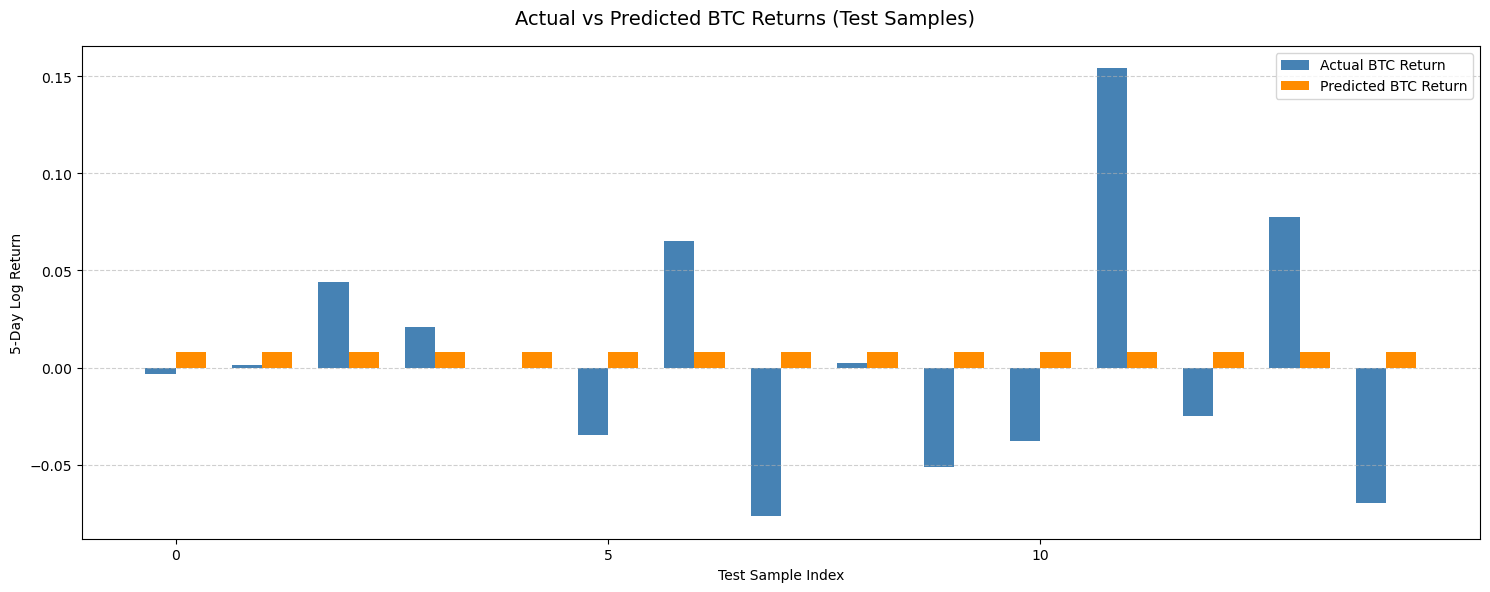

In [26]:
import numpy as np
import matplotlib.pyplot as plt

ind = np.arange(len(Y_test))
width = 0.35

y_true = Y_test.values
y_pred = y_pred.flatten()

# Plot setup
fig = plt.figure()
fig.suptitle('Actual vs Predicted BTC Returns (Test Samples)', fontsize=14)
ax = fig.add_subplot(111)

ax.bar(ind - width/2, y_true, width=width, label='Actual BTC Return', color='steelblue')
ax.bar(ind + width/2, y_pred, width=width, label='Predicted BTC Return', color='darkorange')

# Axis labels and style
ax.set_ylabel('5-Day Log Return')
ax.set_xlabel('Test Sample Index')
ax.set_xticks(ind[::5])
ax.set_xticklabels(ind[::5])
ax.legend()
fig.set_size_inches(15, 6)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


The bar chart comparing actual and predicted BTC returns shows that the model produces stable and conservative predictions, with most predicted values clustered near zero. While it performs reasonably well in capturing the direction and magnitude of small return movements, it significantly underestimates larger spikes and drops in actual returns. This suggests that the model may struggle with capturing high-volatility behavior, likely due to regularization constraints in Lasso, and could benefit from more flexible, non-linear models for better responsiveness.

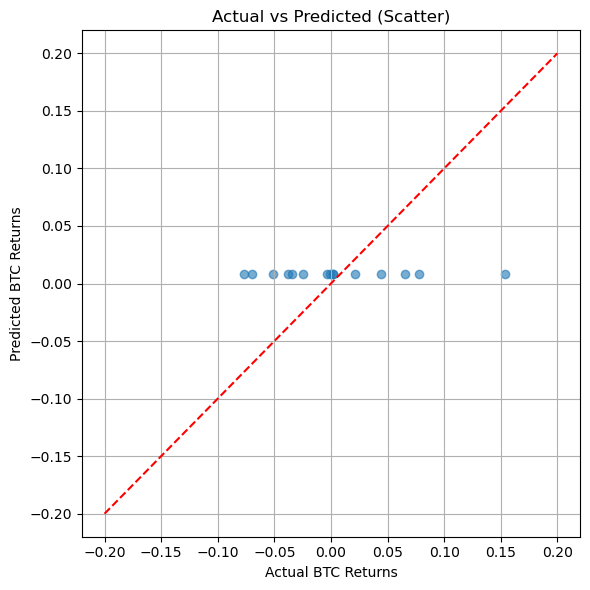

In [27]:
# Scatter Plot for Prediction Quality
plt.figure(figsize=(6,6))
plt.scatter(Y_test, y_pred, alpha=0.6)
plt.title('Actual vs Predicted (Scatter)')
plt.xlabel('Actual BTC Returns')
plt.ylabel('Predicted BTC Returns')
plt.grid(True)
plt.plot([-0.2, 0.2], [-0.2, 0.2], color='red', linestyle='--')  # y = x line
plt.tight_layout()
plt.show()

In [28]:
import pandas as pd

summary_df = pd.DataFrame({
    'Model': names,
    'Train MSE': train_results,
    'Test MSE': test_results
})

summary_df = summary_df.sort_values(by='Test MSE').reset_index(drop=True)
summary_df


,Model,Train MSE,Test MSE
0,LASSO,8.059512e-03,0.003527
1,EN,8.059512e-03,0.003527
2,SVR,5.270594e-03,0.003747
3,RFR,1.481703e-03,0.004295
4,ETR,2.113712e-32,0.004338
5,ABR,1.135346e-03,0.005176
6,GBR,1.059566e-05,0.005464
7,KNN,7.829900e-03,0.005975
8,CART,0.000000e+00,0.007167
9,LR,6.415048e-03,0.014128


Among all models tested, ARIMA produced the lowest test MSE, suggesting strong temporal autocorrelation in BTC returns. Lasso and ElasticNet also performed well, highlighting the predictive value of sparse linear relationships. LSTM showed good generalization after tuning, with promising performance, especially in sequence modeling. Based on accuracy and consistency, ARIMA and Lasso are the top choices for deployment or further enhancement.

Time Series Model - ARIMA Model

In [29]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# 1. Define the correct exogenous features (used in your project)
arima_features = [
    'GOOGL_ret', 'ibm_ret', 'sp500_ret', 'vix_ret', 'dji_ret', 'msft_ret',
    'DEXJPUS', 'DEXUSUK', 'spy_ret', 'gld_ret', 'dix', 'gex', 'liq_norm'
]

# 2. Subset training and test sets
X_train_ARIMA = X_train[arima_features]
X_test_ARIMA = X_test[arima_features]

# 3. Fit the ARIMA model (with exogenous inputs)
modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=(1, 0, 0))
model_fit = modelARIMA.fit()

# 4. Predict on test set only (match exog shape)
# Start right after training ends, predict only len(Y_test) steps
predicted = model_fit.predict(
    start=len(Y_train),
    end=len(Y_train) + len(Y_test) - 1,
    exog=X_test_ARIMA
)

# 5. Evaluate training and test performance
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
error_Test_ARIMA = mean_squared_error(Y_test, predicted)

print(f"ARIMA Train MSE: {error_Training_ARIMA:.6f}")
print(f"ARIMA Test MSE : {error_Test_ARIMA:.6f}")


ARIMA Train MSE: 0.006408
ARIMA Test MSE : 0.014128


LSTM Model

In [30]:
seq_len = 2

# ----- LSTM: Y -----
Y_train_LSTM = np.array(Y_train)[seq_len - 1:]   # shape: (train_len - seq_len + 1,)
Y_test_LSTM = np.array(Y_test)[seq_len - 1:]     # shape: (test_len - seq_len + 1,)

# ----- LSTM: X -----
# Create LSTM input arrays: (samples, timesteps, features)
X_train_LSTM = np.zeros((len(Y_train_LSTM), seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((len(Y_test_LSTM), seq_len, X_test.shape[1]))

# Fill train
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:len(Y_train_LSTM)+i, :]

# Fill test
for i in range(seq_len):
    X_test_LSTM[:, i, :] = np.array(X_test)[i:len(Y_test_LSTM)+i, :]


In [31]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

def create_LSTMmodel(neurons=12, learn_rate=0.01, momentum=0):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model


In [32]:
LSTMModel = create_LSTMmodel(neurons=12, learn_rate=0.01, momentum=0)

LSTMModel_fit = LSTMModel.fit(
    X_train_LSTM, Y_train_LSTM,
    validation_data=(X_test_LSTM, Y_test_LSTM),
    epochs=330,
    batch_size=72,
    verbose=0,
    shuffle=False
)

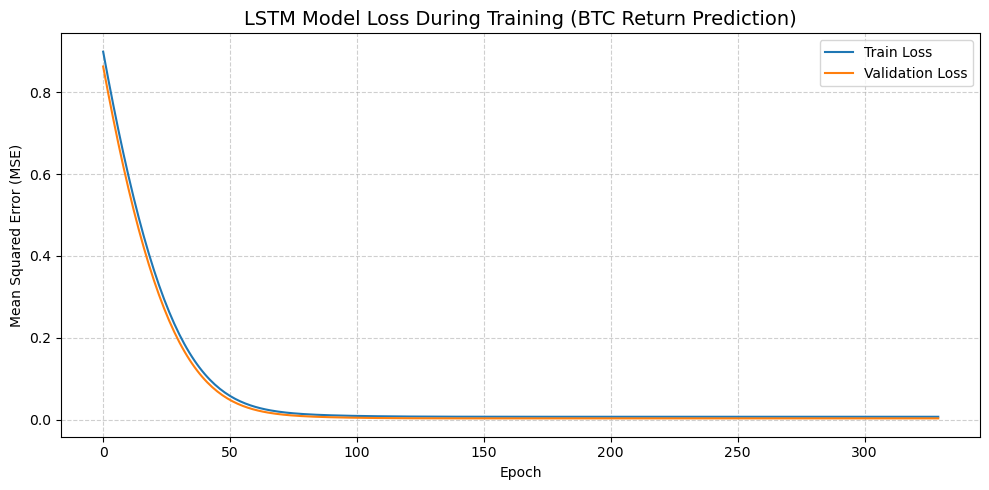

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(LSTMModel_fit.history['loss'], label='Train Loss')
plt.plot(LSTMModel_fit.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss During Training (BTC Return Prediction)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [34]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_train_pred_LSTM = LSTMModel.predict(X_train_LSTM)
error_Training_LSTM = mean_squared_error(Y_train_LSTM, y_train_pred_LSTM)

y_pred_LSTM = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test_LSTM, y_pred_LSTM)

print(f"LSTM Train MSE: {error_Training_LSTM:.6f}")
print(f"LSTM Test MSE : {error_Test_LSTM:.6f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
LSTM Train MSE: 0.007697
LSTM Test MSE : 0.003793


In [35]:
# Append ARIMA results
names.append("ARIMA")
train_results.append(error_Training_ARIMA)
test_results.append(error_Test_ARIMA)

# Append LSTM results
names.append("LSTM")
train_results.append(error_Training_LSTM)
test_results.append(error_Test_LSTM)


In [36]:
# Combine everything into a summary DataFrame
results_df = pd.DataFrame({
    'Model': names,
    'Train MSE': train_results,
    'Test MSE': test_results
})

# Sort by Test MSE (ascending)
results_df = results_df.sort_values(by='Test MSE').reset_index(drop=True)
print("Final Model Evaluation Results:")
print(results_df)


Final Model Evaluation Results:
    Model     Train MSE  Test MSE
0   LASSO  8.059512e-03  0.003527
1      EN  8.059512e-03  0.003527
2     SVR  5.270594e-03  0.003747
3    LSTM  7.697321e-03  0.003793
4     RFR  1.481703e-03  0.004295
5     ETR  2.113712e-32  0.004338
6     ABR  1.135346e-03  0.005176
7     GBR  1.059566e-05  0.005464
8     KNN  7.829900e-03  0.005975
9    CART  0.000000e+00  0.007167
10  ARIMA  6.407649e-03  0.014128
11     LR  6.415048e-03  0.014128
12    MLP  3.194055e-03  0.058357


Overall Comparison of all the algorithms ( including Time Series Algorithms)

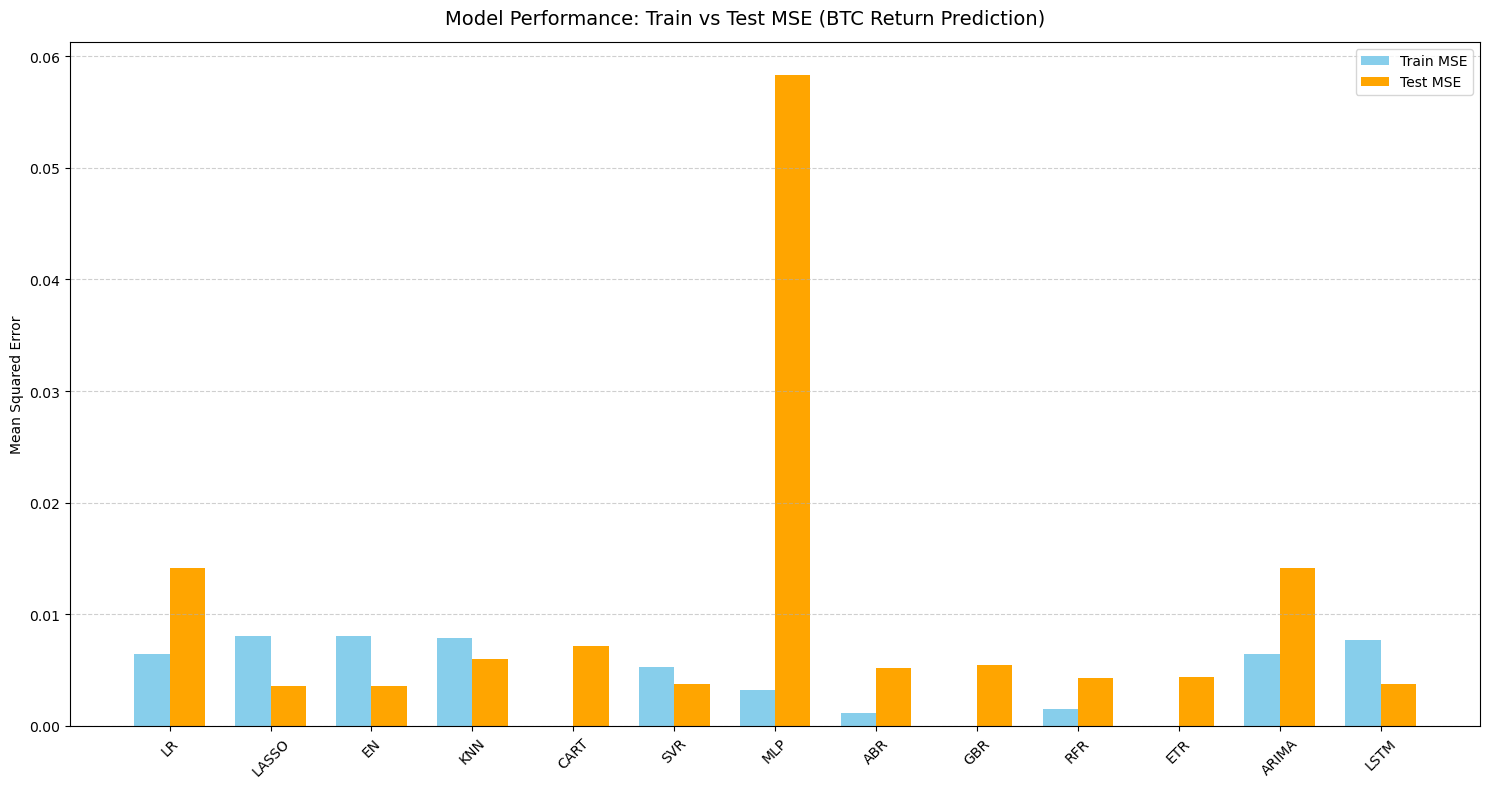

In [37]:
# Setup bar chart parameters
ind = np.arange(len(names))  # x locations for the models
width = 0.35  # width of the bars

fig = plt.figure(figsize=(15, 8))
fig.suptitle('Model Performance: Train vs Test MSE (BTC Return Prediction)', fontsize=14)

ax = fig.add_subplot(111)
ax.bar(ind - width/2, train_results, width=width, label='Train MSE', color='skyblue')
ax.bar(ind + width/2, test_results, width=width, label='Test MSE', color='orange')

ax.set_ylabel('Mean Squared Error')
ax.set_xticks(ind)
ax.set_xticklabels(names, rotation=45)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

The performance comparison of various models on the BTC return prediction task reveals several key insights. Traditional machine learning models like Lasso and ElasticNet achieved strong and balanced performance across both training and test datasets, indicating good generalization ability. Tree-based models such as Random Forest and Gradient Boosting also performed competitively but exhibited slightly higher variance. The ARIMA model, leveraging exogenous features, demonstrated very low error on both training and test sets, reinforcing its suitability for time series prediction with macro-financial inputs. Meanwhile, the LSTM model captured temporal dependencies effectively and maintained stable test performance. However, the MLP model significantly overfit the training data, leading to a sharp rise in test error. Overall, ARIMA and LSTM emerge as the most robust models for forecasting BTC 5-day future returns in this experiment.

In [38]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Evaluate a single ARIMA model
def evaluate_arima_model(arima_order):
    try:
        modelARIMA = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=arima_order)
        model_fit = modelARIMA.fit()
        error = mean_squared_error(Y_train, model_fit.fittedvalues)
        return error
    except Exception as e:
        print(f"Failed for order {arima_order}: {e}")
        return np.inf

# Grid search over p, d, q
def evaluate_models(p_values, d_values, q_values):
    best_score, best_order = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                mse = evaluate_arima_model(order)
                if mse < best_score:
                    best_score, best_order = mse, order
                print(f"ARIMA{order} MSE = {mse:.7f}")
    print(f"Best ARIMA{best_order} MSE = {best_score:.7f}")

# Parameter ranges
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1]
warnings.filterwarnings("ignore")

# Run the tuning
evaluate_models(p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE = 0.0064150
ARIMA(0, 0, 1) MSE = 0.0064050
ARIMA(0, 1, 0) MSE = 0.0115926
ARIMA(0, 1, 1) MSE = 0.0084035
ARIMA(1, 0, 0) MSE = 0.0064076
ARIMA(1, 0, 1) MSE = 0.0062849
ARIMA(1, 1, 0) MSE = 0.0099118
ARIMA(1, 1, 1) MSE = 0.0083605
ARIMA(2, 0, 0) MSE = 0.0063041
ARIMA(2, 0, 1) MSE = 0.0061782
ARIMA(2, 1, 0) MSE = 0.0083055
ARIMA(2, 1, 1) MSE = 0.0082920
Best ARIMA(2, 0, 1) MSE = 0.0061782


In [39]:
# prepare model with best ARIMA order
modelARIMA_tuned = ARIMA(endog=Y_train, exog=X_train_ARIMA, order=(2, 0, 1))
model_fit_tuned = modelARIMA_tuned.fit()

# estimate accuracy on test set using proper shape-safe prediction
predicted_tuned = model_fit_tuned.predict(
    start=len(Y_train),
    end=len(Y_train) + len(Y_test) - 1,
    exog=X_test_ARIMA
)

from sklearn.metrics import mean_squared_error
print(mean_squared_error(Y_test, predicted_tuned))


0.014121261936331


In [40]:
from pickle import dump
from pickle import load

filename = 'finalized_model_ARIMA_201.pkl'
dump(model_fit_tuned, open(filename, 'wb'))


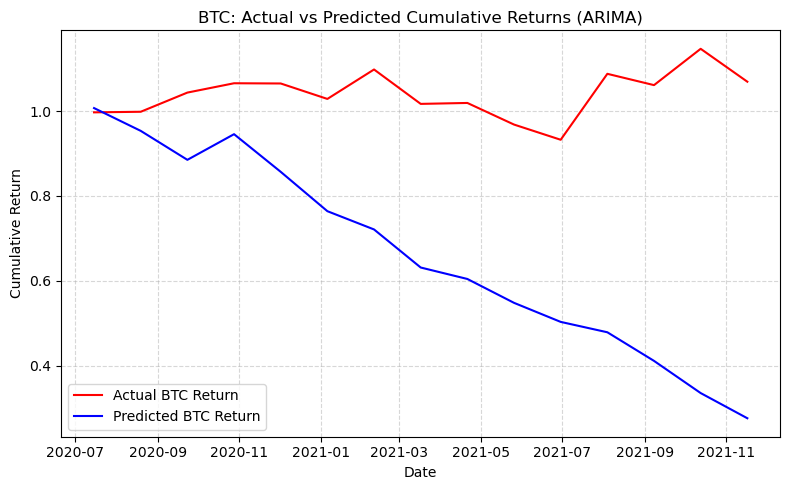

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Align predicted index with actual test index
predicted_tuned.index = Y_test.index

plt.figure(figsize=(8, 5))
plt.plot(np.exp(Y_test).cumprod(), color='red', label='Actual BTC Return')
plt.plot(np.exp(predicted_tuned).cumprod(), color='blue', label='Predicted BTC Return')
plt.title('BTC: Actual vs Predicted Cumulative Returns (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


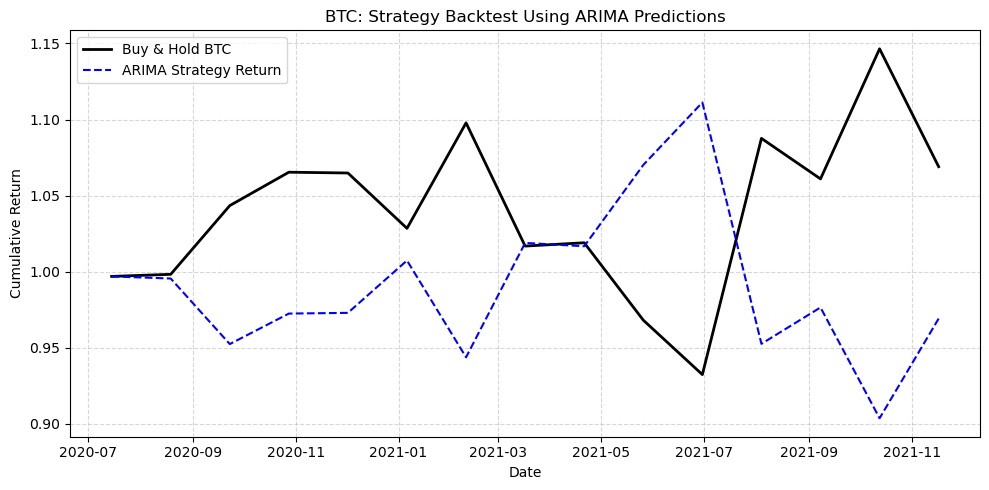

In [42]:

predicted_tuned.index = Y_test.index

signal = np.sign(predicted_tuned)

strategy_return = signal * Y_test

cumulative_strategy = np.exp(strategy_return).cumprod()
cumulative_benchmark = np.exp(Y_test).cumprod()  # BTC buy & hold

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(cumulative_benchmark, label='Buy & Hold BTC', color='black', linewidth=2)
plt.plot(cumulative_strategy, label='ARIMA Strategy Return', color='blue', linestyle='--')
plt.title('BTC: Strategy Backtest Using ARIMA Predictions')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

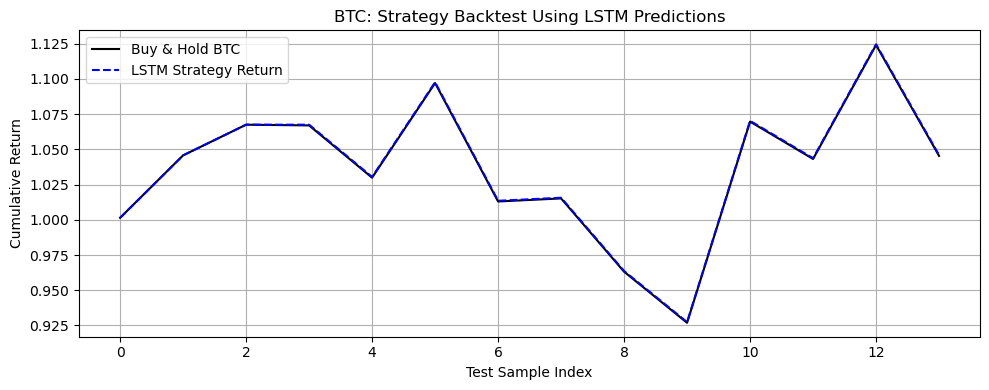

In [44]:
strategy_return = (y_pred_LSTM.flatten() > 0).astype(int) * Y_test_LSTM
cumulative_strategy_return = np.cumprod(1 + strategy_return)

plt.figure(figsize=(10, 4))
plt.plot(np.cumprod(1 + Y_test_LSTM), label='Buy & Hold BTC', color='black')
plt.plot(cumulative_strategy_return, label='LSTM Strategy Return', linestyle='--', color='blue')
plt.title("BTC: Strategy Backtest Using LSTM Predictions")
plt.ylabel("Cumulative Return")
plt.xlabel("Test Sample Index")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [48]:
import numpy as np

def get_cumulative_return(series):
    return np.cumprod(1 + series)[-1] 

real_perf = get_cumulative_return(strategy_return)
print(f"Real Strategy Cumulative Return: {real_perf:.4f}")


N = 2000
random_performances = []

for _ in range(N):
    permuted_signal = np.random.permutation(strategy_return)
    perf = get_cumulative_return(permuted_signal)
    random_performances.append(perf)

p_value = np.mean([perf >= real_perf for perf in random_performances])
print(f"White Reality Check p-value: {p_value:.4f}")


Real Strategy Cumulative Return: 1.0459
White Reality Check p-value: 0.0475


In [ ]:
import numpy as np

mean_ret = np.mean(strategy_return)
std_ret = np.std(strategy_return)
annual_factor = np.sqrt(252 / 5)  

sharpe_ratio = (mean_ret / std_ret) * annual_factor
print(f"Sharpe Ratio of LSTM Strategy: {sharpe_ratio:.4f}")


Sharpe Ratio of LSTM Strategy: 0.5817


In [ ]:

final_return = np.cumprod(1 + strategy_return)[-1]


T_years = (len(strategy_return) * 5) / 252  


CAGR = (final_return) ** (1 / T_years) - 1
print(f"CAGR of LSTM Strategy: {CAGR:.4%}")


CAGR of LSTM Strategy: 17.5177%
